In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import dill
import json

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets import IrisDataset, SklearnDataset
# for QASVM
from classifiers.quantum.qasvm import SoftQASVM, PseudoSoftQASVM
from classifiers.convex.svm import CvxSoftQASVM
from classifiers.quantum.ansatz import Circuit9, sample_circuit, MultilayerCircuit9FeatureMap
from classifiers.callback import CostParamStorage
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator, StatevectorSimulator, Aer, QasmSimulator
# for optimization
from qiskit.algorithms.optimizers import SPSA, ADAM
from tqdm.notebook import tqdm

In [4]:
dataset = SklearnDataset('iris', feature_range=(-np.pi, np.pi), true_hot=None)
with open('./circuits_benchmarking/setting.json', 'r') as fp:
    random_seed = json.load(fp)['Repetition setting']['SEED']
with open('./circuits_benchmarking/setting.json', 'r') as fp:
    training_size = json.load(fp)['Data set selection']['TRAINING_SIZE']
with open('./circuits_benchmarking/setting.json', 'r') as fp:
    test_size = json.load(fp)['Data set selection']['TEST_SIZE']
random_seed, training_size, test_size

(86679, 64, 86)

In [5]:
# dataset = IrisDataset(feature_range=(-np.pi, np.pi))
data, lable, label_names, features = dataset.data, dataset.target, dataset.target_names, dataset.feature_names

classes = list(label_names)
training_set, test_set = SklearnDataset('iris', feature_range=(-np.pi, np.pi)).sample_training_and_test_dataset((training_size, test_size), random_state = 12983047)
training_data = training_set[features].to_numpy()
training_label = training_set['target'].to_numpy()
test_data = test_set[features].to_numpy()
test_label = test_set['target'].to_numpy()
training_labels = {__l:  np.where(training_label==__i, 1, 0) for __i, __l in enumerate(classes)}
test_labels = {__l:  np.where(test_label==__i, 1, 0) for __i, __l in enumerate(classes)}

In [6]:
np.all(training_data==np.load('./circuits_benchmarking/Dataset #0/training_data.npy')), np.all(test_data==np.load('./circuits_benchmarking/Dataset #0/test_data.npy'))

(False, False)

In [7]:
backend = StatevectorSimulator(device='CPU', shots=2**13)
backend.options

Options(shots=8192, device='CPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=None, max_parallel_shots=None, max_memory_mb=None, seed_simulator=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=5, fusion_threshold=14, statevector_parallel_threshold=14)

In [8]:
var_form = sample_circuit(15)(num_qubits=int(np.log2(training_size)), reps=5)
quantum_instance = QuantumInstance(backend=backend, shots=2**13)

MAXITER = 2**13

In [9]:
label_index = 0

from tqdm.notebook import tqdm
from itertools import product

feature_map = MultilayerCircuit9FeatureMap(4, 2)

from sklearn.svm import SVC
__qasvm = PseudoSoftQASVM(
        training_data, training_labels[classes[label_index]], lamda=1, C=10,
        quantum_instance=quantum_instance,
        var_form=None,
        feature_map=feature_map
    )
kernel_matrix = __qasvm.kernel_matrix
hyperC = 10**np.linspace(-4, 4, 5)
lamdas = 10**np.linspace(-10, 10, 5)
X, Y = np.meshgrid(hyperC, lamdas)
Z = np.empty_like(X)

In [10]:
with tqdm(total = len(X.flatten())) as pbar:
    for i, _X in enumerate(X):
        for j, _ in enumerate(_X):
            svm = SVC(C=X[i, j], kernel='precomputed')
            svm.fit(kernel_matrix+1/Y[i, j], training_labels[classes[label_index]])
            accuracy = svm.score(__qasvm._qk.evaluate(test_data, training_data)+1/Y[i, j], test_labels[classes[label_index]])
            # svm = SVC(C=X[i, j], kernel='rbf')
            # svm.fit(training_data, training_labels[classes[label_index]])
            # accuracy = svm.score(test_data, test_labels[classes[label_index]])
            Z[i, j] = accuracy
            pbar.update()

  0%|          | 0/25 [00:00<?, ?it/s]

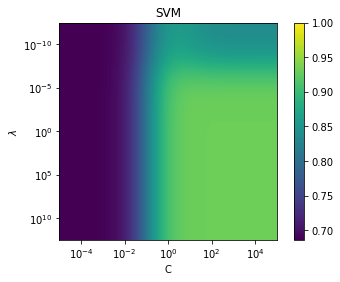

In [11]:
fig, ax = plt.subplots()
cs = ax.imshow(Z, interpolation='gaussian')
ax.set_xlabel('C')
ax.set_ylabel(r'$\lambda$')
ax.set_xticks(np.arange(len(hyperC)))
ax.set_xticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(hyperC))))
ax.set_yticks(np.arange(len(lamdas)))
ax.set_yticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(lamdas))))
ax.set_title('SVM')
cs.set_clim(None, 1)
fig.colorbar(cs)

In [12]:
Z_ = np.empty_like(Z)
with tqdm(total = len(X.flatten())) as pbar:
    def callback(*args):
        pass
    for i, _X in enumerate(X):
        for j, _ in enumerate(_X):
            qasvm = CvxSoftQASVM(kernel='precomputed', C=X[i, j], lamda=Y[i, j])
            qasvm.fit(kernel_matrix, training_labels[classes[label_index]])
            accuracy2 = qasvm.score(__qasvm._qk.evaluate(test_data, training_data), test_labels[classes[label_index]])

            Z_[i, j] = accuracy2
            pbar.update()

  0%|          | 0/25 [00:00<?, ?it/s]

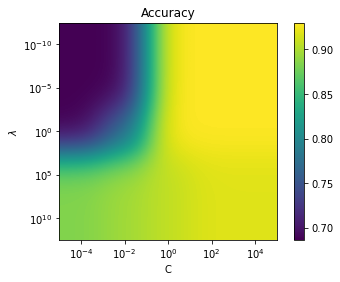

In [19]:
fig, ax = plt.subplots()
cs = ax.imshow(Z_, interpolation='gaussian')
ax.set_xlabel('C')
ax.set_ylabel(r'$\lambda$')
ax.set_xticks(np.arange(len(hyperC)))
ax.set_xticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(hyperC))))
ax.set_yticks(np.arange(len(lamdas)))
ax.set_yticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(lamdas))))
ax.set_title('Accuracy')
# cs.set_clim(None, 1)
fig.colorbar(cs)

In [18]:
Z_

array([[0.68604651, 0.68604651, 0.93023256, 0.93023256, 0.93023256],
       [0.68604651, 0.68604651, 0.93023256, 0.93023256, 0.93023256],
       [0.68604651, 0.76744186, 0.93023256, 0.93023256, 0.93023256],
       [0.88372093, 0.89534884, 0.90697674, 0.91860465, 0.91860465],
       [0.88372093, 0.89534884, 0.90697674, 0.91860465, 0.91860465]])

In [14]:
a, b = np.argwhere(Z_==max(Z_.flatten()))[-1]
_opt_C, _opt_l = hyperC[a], lamdas[b]

In [14]:
layers = np.arange(1, 21, 2)
var_forms = [sample_circuit(15)(num_qubits=int(np.log2(len(training_data))), reps=_r) for _r in layers]
accuracy_list = []
num_params_list = []
last_cost_list = []
qasvm_list = []
result_list = []

for i, layer in enumerate(tqdm(layers)):
    qasvm = PseudoSoftQASVM(
        data=training_data, label=training_labels[classes[label_index]],
        quantum_instance=quantum_instance,
        feature_map=feature_map,
        var_form=var_forms[i],
        lamda=_opt_l, C=_opt_C
    )
    with tqdm(total=2**10) as pbar:
        pbar.set_description(f'layer: {layer}')
        def callback(*args):
            pbar.update()
        optimzer = SPSA(maxiter=2**10, blocking=True, callback=callback)
        result = optimzer.minimize(qasvm.cost_fn, qasvm.initial_point)
    qasvm.parameters = result.x
    accuracy = qasvm.accuracy(test_data, test_labels[classes[label_index]])
    accuracy_list.append(accuracy)
    num_params_list.append(qasvm.num_parameters)
    last_cost_list.append(result.fun)
    qasvm_list.append(qasvm)
    result_list.append(result)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

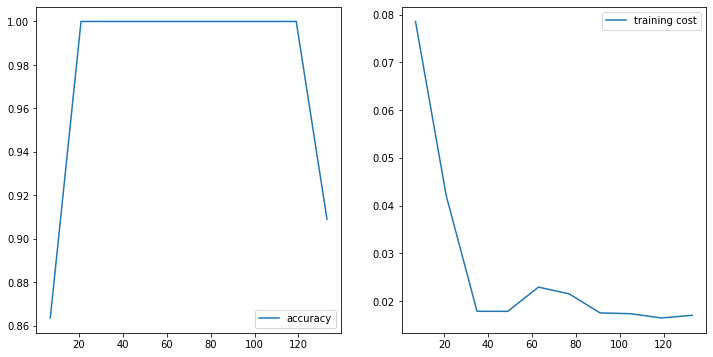

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(num_params_list, accuracy_list, label='accuracy')
axes[1].plot(num_params_list, last_cost_list, label='training cost')
axes[0].legend()
axes[1].legend()

In [16]:
layers = np.arange(1, 21, 2)
var_forms = [sample_circuit(9)(num_qubits=int(np.log2(len(training_data))), reps=_r) for _r in layers]
_accuracy_list = []
_num_params_list = []
_last_cost_list = []
_qasvm_list = []
_result_list = []

for i, layer in enumerate(tqdm(layers)):
    qasvm = PseudoSoftQASVM(
        data=training_data, label=np.where(training_set['target'].to_numpy()==label_index, 1, 0),
        quantum_instance=quantum_instance,
        feature_map=feature_map,
        var_form=var_forms[i],
        lamda=_opt_l, C=_opt_C
    )
    with tqdm(total=2**10) as pbar:
        pbar.set_description(f'layer: {layer}')
        def callback(*args):
            pbar.update()
        optimzer = SPSA(maxiter=2**10, blocking=True, callback=callback)
        result = optimzer.minimize(qasvm.cost_fn, qasvm.initial_point)
    qasvm.parameters = result.x
    accuracy = qasvm.accuracy(test_data, test_labels[classes[label_index]])
    _accuracy_list.append(accuracy)
    _num_params_list.append(qasvm.num_parameters)
    _last_cost_list.append(result.fun)
    _qasvm_list.append(qasvm)
    _result_list.append(result)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

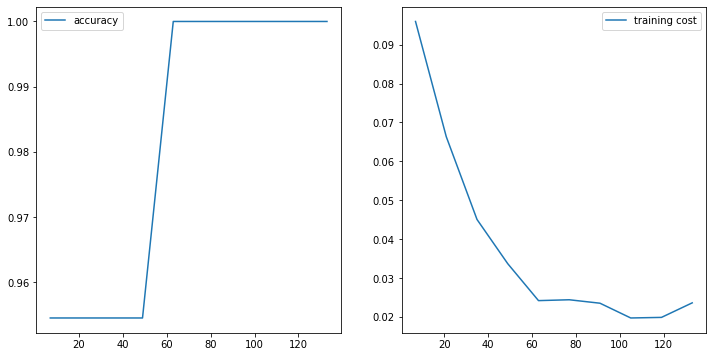

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(_num_params_list, _accuracy_list, label='accuracy')
axes[1].plot(_num_params_list, _last_cost_list, label='training cost')
axes[0].legend()
axes[1].legend()

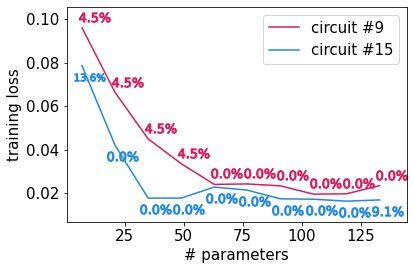

In [18]:
import matplotlib
matplotlib.rcParams['font.size'] = 15

plt.plot(_num_params_list, _last_cost_list, label='circuit #9', color='#D81B60')
for _x, _y, _a in zip(_num_params_list, _last_cost_list, _accuracy_list):
    plt.scatter([_x+5], [_y+0.005], marker="${:.1%}$%".format(1-_a), c='#D81B60', s=1000)

plt.plot(num_params_list, last_cost_list, label='circuit #15', color='#1E88E5')
for _x, _y, _a in zip(num_params_list, last_cost_list, accuracy_list):
    plt.scatter([_x+3], [_y-0.005], marker="${:.1%}$%".format(1-_a), c='#1E88E5', s=1000)
plt.xlabel("# parameters")
plt.ylabel("training loss")
plt.legend()
plt.tight_layout()

In [19]:
circuit15_result = dict(
    accuracy_list = accuracy_list,
    num_params_list = num_params_list,
    last_cost_list = last_cost_list,
    qasvm_list = qasvm_list,
    result_list = result_list,
)

circuit9_result = dict(
    accuracy_list = _accuracy_list,
    num_params_list = _num_params_list,
    last_cost_list = _last_cost_list,
    qasvm_list = _qasvm_list,
    result_list = _result_list,
)

import dill

with open(f'./circuit15result(label{label_index})_6_18', 'wb') as fp:
    dill.dump(circuit15_result, fp)
with open(f'./circuit9result(label{label_index})_6_18', 'wb') as fp:
    dill.dump(circuit9_result, fp)

In [20]:
qasvm = CvxSoftQASVM(kernel='precomputed', C=_opt_C, lamda=_opt_l)
qasvm.fit(kernel_matrix, training_labels[classes[label_index]])
qasvm.dual_objective_value

0.010577528195686378